In [1]:
#Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import Image
from lxml import objectify
import math
import time
from pytrends.request import TrendReq
from wordcloud import WordCloud
from ast import literal_eval
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_linear_regression
import numpy as np

#Import data from wikidata.org
from wikidata2df import wikidata2df

#Convert country name to ISO-3
import country_converter as coco

#World map plot librairies
import plotly.offline as po
import plotly.graph_objs as pg
import plotly.express as px
import plotly.graph_objs as go

# Analysis of the lexical fields
from empath import Empath 

#Warnings
import warnings

data_folder = './data/'

In [2]:
df_movie_usa = pd.read_csv('df_movie_usa.csv')
df_character_usa = pd.read_csv('df_character_usa.csv')
df_movie_usa = df_movie_usa.dropna(subset=['Principal_character_actor'])
df_movie_usa

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,TS score_x,...,beautiful,positive_emotion,negative_emotion,Number_of_words,he_count,she_count,Principal_summary_character,Secondary_summary_character,Principal_character_sex,Principal_character_actor
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",22%,...,0.0,0.0,7.0,396.0,1.0,0.0,Ballard,Williams,F,Natasha Henstridge
7,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"[""Children's/Family"", 'Musical', 'Fantasy', 'C...",NaN,...,0.0,8.0,5.0,1678.0,12.0,7.0,Mary,Banks,F,Julie Andrews
13,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Crime Fiction', 'Drama', 'Coming of age']",71%,...,0.0,4.0,9.0,730.0,11.0,4.0,Jody,Yvette,M,Tyrese Gibson
20,25960460,/m/0b6kc_5,Daddy and Them,2001,NaN,101.0,"{""/m/02h40lc"": ""English Language""}","['United States of America', 'Netherlands']","['Black comedy', 'Comedy']",86%,...,0.0,1.0,0.0,71.0,0.0,0.0,Claude,Montgomery,M,Billy Bob Thornton
25,4951456,/m/0cws46,Kinjite: Forbidden Subjects,1989,3416846.0,97.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Crime Fiction', 'Action/Adventure', 'Action'...",0%,...,0.0,0.0,3.0,334.0,2.0,2.0,Crowe,NaN,F,Peggy Lipton
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34388,26219108,/m/0b76gfr,The Leopard Woman,NaN,NaN,70.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",['United States of America'],"['Silent film', 'Romance Film']",NaN,...,0.0,5.0,2.0,306.0,1.0,3.0,Culbertson,Chak,NaN,Shirley MacLaine
34389,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Romantic comedy', 'Comedy of manners', 'Dram...",72%,...,0.0,6.0,4.0,548.0,10.0,0.0,Akeem,Lisa,M,Eddie Murphy
34393,22330502,/m/05sync6,Inspiration,1931-01-31,NaN,74.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Drama', 'Black-and-white']",NaN,...,0.0,2.0,0.0,164.0,2.0,0.0,Yvonne,Valbret,F,Greta Garbo
34403,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","['France', 'United States of America']","['Parody', 'Americana', 'Comedy']",85%,...,0.0,2.0,1.0,252.0,1.0,1.0,Carla,Walt,F,Julia Stiles


In [3]:
dfactor_gender = df_character_usa[['Actor_name','Actor_gender']]
dfactor_gender = dfactor_gender.drop_duplicates()

In [4]:
merge = df_movie_usa.merge(dfactor_gender, left_on='Principal_character_actor', right_on='Actor_name', how='left')
df_movie_usa = merge.drop(columns=['Principal_character_sex'])

In [5]:
#df_movie_usa = pd.read_csv('df_movie_usa.csv')
df_movie_usa = df_movie_usa[(df_movie_usa.Actor_gender == 'M') | (df_movie_usa.Actor_gender == 'F')]
df_movie_usa = df_movie_usa.dropna(subset=['Movie_date'])
df_movie_usa = df_movie_usa.dropna(subset=['RT average_x'])
df_movie_usa['year'] = df_movie_usa['Movie_date'].apply(lambda x: int(x[0:4]))
df_movie_usa['TS score_x'] = df_movie_usa['TS score_x'].str.replace("\%", "", regex=True)
df_movie_usa['RT average_x'] = df_movie_usa['RT average_x'].str.split('/').str[0].astype(float)
df_movie_usa['TS score_x'] = df_movie_usa['TS score_x'].astype(float)
df_movie_usa.rename(columns = {'TS score_x':'TSscore', 'RT average_x':'RTaverage'}, inplace = True)

In [6]:
decades = ['1900-1910','1910-1920','1920-1930','1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010','2010-2020']
decades_code = range(len(decades))
df_movie_usa['Decade'] = 0
for ctr,decade in enumerate(decades):
    index1 = df_movie_usa[ (df_movie_usa['year']>=int(decade[0:4])) & (df_movie_usa['year']<int(decade[5:9]))].index
    df_movie_usa.loc[index1,'Decade'] = decades_code[ctr]

In [7]:
df_movie_usa['gender'] = df_movie_usa['Actor_gender'].apply(lambda x: 1 if x =='M' else 0)

In [8]:
df_movie_group = df_movie_usa.groupby(['Decade'],group_keys = True).apply(lambda x:x)
df_movie_group.index = df_movie_group.index.droplevel(1)
df_movie_group.rename_axis(None, axis=1).rename_axis('id', axis=0)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,TSscore,...,he_count,she_count,Principal_summary_character,Secondary_summary_character,Principal_character_actor,Actor_name,Actor_gender,year,Decade,gender
id,,,,,,,,,,,,,,,,,,,,,
1,3333,/m/0151l,The Birth of a Nation,1915,50000000.0,190.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",['United States of America'],"['Silent film', 'Indie', 'Costume drama', 'Epi...",93.0,...,8.0,7.0,Cameron,Elsie,Bette Davis,Bette Davis,F,1915,1,0
1,73380,/m/0jq5p,Broken Blossoms,1919,NaN,75.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Silent film', 'Indie', 'Black-and-white', 'D...",95.0,...,3.0,0.0,Cheng,Lucy,Olivia de Havilland,Olivia de Havilland,F,1919,1,0
1,238484,/m/01jlds,Tillie's Punctured Romance,1914-11-14,NaN,86.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Romantic comedy', 'Silent film', 'Indie', 'B...",90.0,...,6.0,6.0,Tillie,Chaplin,Chris Bruno,Chris Bruno,M,1914,1,1
2,73432,/m/0jqkx,The Docks of New York,1928,NaN,75.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",['United States of America'],"['Silent film', 'Drama', 'Indie', 'Black-and-w...",100.0,...,4.0,1.0,Bill,Mae,Abigail Breslin,Abigail Breslin,F,1928,2,0
2,3831825,/m/0b28p3,The Freshman,1925-09-20,2600000.0,76.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",['United States of America'],"['Silent film', 'Indie', 'Black-and-white', 'C...",94.0,...,12.0,1.0,Harold,Peggy,Mark Hamill,Mark Hamill,M,1925,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,34025292,/m/0gwxf3x,The Five-Year Engagement,2012-04-27,53774508.0,124.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Romance Film', 'Comedy film']",64.0,...,8.0,8.0,Tom,Winton,Jason Segel,Jason Segel,M,2012,11,1
11,16578764,/m/07_k0c0,The A-Team,2010-06-03,177238796.0,133.0,"{""/m/064_8sq"": ""French Language"", ""/m/071fb"": ...",['United States of America'],"['Action/Adventure', 'Thriller', 'Action', 'Ad...",49.0,...,4.0,2.0,Morrison,Pike,Gerald McRaney,Gerald McRaney,M,2010,11,1
11,31422455,/m/0dkc35r,A Very Harold & Kumar 3D Christmas,2011-11-04,35387212.0,108.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],['Comedy'],68.0,...,14.0,1.0,Harold,Kumar,John Cho,John Cho,M,2011,11,1


In [9]:
df_matched = pd.DataFrame()
# For loop on the unique index in df4
for i in list(df_movie_group.index.value_counts().index):
    count = df_movie_group.loc[i]['gender'].value_counts()               # Count the number of 0 and 1
    l = len(count)                                              # Count number of elements (1 if only 0 or 1)
    df_temp = df_movie_group.loc[i]                                        # temporary DF containing elements that has the same index
    min = count.min()                                           # report the minimum value between number of 0 and number of 1
    if l != 2:                                                  #continue if only 0 or only 1
        continue
    df1 = df_temp[df_temp.gender == 0].sample(min)            # select randomly a number of values corresponding to the minimum occurence of 0 or 1
    df2 = df_temp[df_temp.gender == 1].sample(min)
    df_matched = pd.concat([df1,df2,df_matched])                # join the results in df_matched
    

print('The number of actors discarded is : '+ str(len(df_movie_group)-len(df_matched)))
print('The number of matched pairs is : '+ str(int(len(df_matched)/2)))

The number of actors discarded is : 2654
The number of matched pairs is : 1780


In [10]:
mod = smf.ols(formula='RTaverage ~ gender + Decade', data=df_matched)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     369.8
Date:                Tue, 20 Dec 2022   Prob (F-statistic):          1.21e-146
Time:                        11:24:32   Log-Likelihood:                -6061.9
No. Observations:                3560   AIC:                         1.213e+04
Df Residuals:                    3557   BIC:                         1.215e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2846      0.098     84.655      0.0

eval_env: 1
eval_env: 1
eval_env: 1


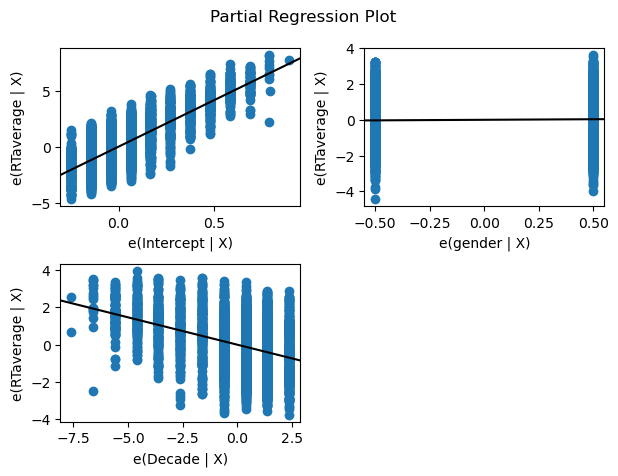

In [11]:
fig = sm.graphics.plot_partregress_grid(res)
fig.tight_layout(pad=1.0)

# Revenue

In [12]:
df_movie_usa = pd.read_csv('df_movie_usa.csv')
df_movie_usa = df_movie_usa.dropna(subset=['Principal_character_actor'])
dfactor_gender = df_character_usa[['Actor_name','Actor_gender']]
dfactor_gender = dfactor_gender.drop_duplicates()
merge = df_movie_usa.merge(dfactor_gender, left_on='Principal_character_actor', right_on='Actor_name', how='left')
df_movie_usa = merge.drop(columns=['Principal_character_sex'])
df_movie_usa = df_movie_usa[(df_movie_usa.Actor_gender == 'M') | (df_movie_usa.Actor_gender == 'F')]
df_character_usa = pd.read_csv('df_character_usa.csv')
df_movie_usa = df_movie_usa.dropna(subset=['Movie_date'])
df_movie_usa['year'] = df_movie_usa['Movie_date'].apply(lambda x: int(x[0:4]))
df_movie_usa['Movie_revenue'] = df_movie_usa['Movie_revenue'].astype(float)
df_movie_usa = df_movie_usa.dropna(subset=['Movie_revenue'])
df_movie_usa['gender'] = df_movie_usa['Actor_gender'].apply(lambda x: 1 if x =='M' else 0)

In [13]:
decades = ['1900-1910','1910-1920','1920-1930','1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010','2010-2020']
decades_code = range(len(decades))
df_movie_usa['Decade'] = 0
for ctr,decade in enumerate(decades):
    index1 = df_movie_usa[ (df_movie_usa['year']>=int(decade[0:4])) & (df_movie_usa['year']<int(decade[5:9]))].index
    df_movie_usa.loc[index1,'Decade'] = decades_code[ctr]

In [14]:
#create a SPARQL wikidata query to retrieve the rotten tomatoes score review when available
US_rev = '''
SELECT ?film ?reviewLabel ?freebase_ID ?score_byLabel ?methodLabel WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  ?film wdt:P31 wd:Q11424;      #select all the instances that has the 'film' category
    wdt:P495 wd:Q30;            #select the films that comes from the US
    wdt:P646 ?freebase_ID;      #retrieve the freebase_ID
    p:P444 ?revieww.            #filter the movies that has a review score
    ?revieww ps:P444 ?review;   #display the review score
    pq:P447 ?score_by;          #display the origin of the review
    pq:P459 ?method.            #display the method used by the review (tomatometer score, average score)
}
'''
US_film_rev = wikidata2df(US_rev)  #convert the json file from the query into a pandas dataframe

In [15]:
box = '''
SELECT ?revenueLabel ?freebase_ID ?in
WHERE {
    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
    ?movie wdt:P31 wd:Q11424;
    wdt:P495 wd:Q30;
    wdt:P646 ?freebase_ID;
    p:P2142 ?revenuee.
    ?revenuee ps:P2142 ?revenue.
}
'''

In [16]:
boxdf = wikidata2df(box)
boxdf

,revenueLabel,freebase_ID
0,89328627,/m/0rfdcdn
1,312242626,/m/0w01nbr
2,203300000,/m/0vpv29q
3,18700000,/m/0tkj5w3
4,24177137,/m/0w2zz_z
...,...,...
2114,677718395,/m/010qw4zb
2115,222267273,/m/010qw4zb
2116,880674609,/m/0p3rfy6
2117,95200787,/m/0p3rfy6


In [17]:
df_movie_usamerged = df_movie_usa.merge(boxdf, left_on='Freebase_movie_ID', right_on='freebase_ID', how='left')
df_movie_usamerged['Movie_revenue'] =  df_movie_usamerged['revenueLabel'].combine_first(df_movie_usamerged['Movie_revenue'])

In [18]:
df_matched = pd.DataFrame()
# For loop on the unique index in df4
for i in list(df_movie_group.index.value_counts().index):
    count = df_movie_group.loc[i]['gender'].value_counts()               # Count the number of 0 and 1
    l = len(count)                                              # Count number of elements (1 if only 0 or 1)
    df_temp = df_movie_group.loc[i]                                        # temporary DF containing elements that has the same index
    min = count.min()                                           # report the minimum value between number of 0 and number of 1
    if l != 2:                                                  #continue if only 0 or only 1
        continue
    df1 = df_temp[df_temp.gender == 0].sample(min)            # select randomly a number of values corresponding to the minimum occurence of 0 or 1
    df2 = df_temp[df_temp.gender == 1].sample(min)
    df_matched = pd.concat([df1,df2,df_matched])                # join the results in df_matched
    

print('The number of actors discarded is : '+ str(len(df_movie_group)-len(df_matched)))
print('The number of matched pairs is : '+ str(int(len(df_matched)/2)))

The number of actors discarded is : 2654
The number of matched pairs is : 1780


## Log_revenue as a function of gender

In [19]:
df_matched.rename(columns={'TS score_x':'TSscore'}, inplace=True)

In [20]:
df_matched= df_matched.dropna(subset=['Movie_date'])

In [21]:
df_matched['year'] = df_matched['Movie_date'].apply(lambda x: int(x[0:4]))

In [22]:
df_matched['log_revenue'] = np.log(df_matched['Movie_revenue'])

In [23]:
df_matched.loc[[1,2,3,4,5]]

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,TSscore,...,she_count,Principal_summary_character,Secondary_summary_character,Principal_character_actor,Actor_name,Actor_gender,year,Decade,gender,log_revenue
Decade,,,,,,,,,,,,,,,,,,,,,
1,3333,/m/0151l,The Birth of a Nation,1915,50000000.0,190.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",['United States of America'],"['Silent film', 'Indie', 'Costume drama', 'Epi...",93.0,...,7.0,Cameron,Elsie,Bette Davis,Bette Davis,F,1915,1,0,17.727534
1,238484,/m/01jlds,Tillie's Punctured Romance,1914-11-14,NaN,86.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Romantic comedy', 'Silent film', 'Indie', 'B...",90.0,...,6.0,Tillie,Chaplin,Chris Bruno,Chris Bruno,M,1914,1,1,NaN
2,3566585,/m/09l_6k,The Unknown,1927,NaN,181.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",['United States of America'],"['Horror', 'Silent film', 'Drama', 'Indie', 'B...",100.0,...,9.0,Nanon,Antonio,Joan Crawford,Joan Crawford,F,1927,2,0,NaN
2,2509613,/m/07jwm1,The Lost World,1925-02-02,NaN,93.0,"{""/m/06ppq"": ""Silent film""}",['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",100.0,...,0.0,Paula,Roxton,Bessie Love,Bessie Love,F,1925,2,0,NaN
2,68388,/m/0hwt7,The General,1926-12-31,1000000.0,75.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",['United States of America'],"['Romance Film', 'Action', 'Comedy', 'War film']",93.0,...,2.0,Johnnie,Annabelle,Cloris Leachman,Cloris Leachman,F,1926,2,0,13.815511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,84213,/m/0lgdg,Decision Before Dawn,1951-12-21,1550000.0,119.0,"{""/m/064_8sq"": ""French Language"", ""/m/02h40lc""...",['United States of America'],"['Thriller', 'Action', 'Drama', 'War film', 'S...",100.0,...,1.0,Devlin,Rennick,Gary Merrill,Gary Merrill,M,1951,5,1,14.253765
5,1809672,/m/05ypj5,The Glenn Miller Story,1953-12-10,7000000.0,115.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Biography', 'Musical', 'Period piece', 'Dram...",88.0,...,0.0,Miller,Glenn,James Stewart,James Stewart,M,1953,5,1,15.761421
5,261107,/m/01mr29,Strangers on a Train,1951,1800000.0,101.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Thriller', 'LGBT', 'Psychological thriller',...",98.0,...,1.0,Bruno,Anne,Robert Walker,Robert Walker,M,1951,5,1,14.403297


In [24]:
mod = smf.ols(formula='log_revenue ~ gender+year', data=df_matched.loc[[4,5,6,7]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     82.23
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           1.35e-28
Time:                        11:24:46   Log-Likelihood:                -416.83
No. Observations:                 272   AIC:                             839.7
Df Residuals:                     269   BIC:                             850.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -144.6641     12.539    -11.537      0.0

In [25]:
mod = smf.ols(formula='log_revenue ~ gender+year', data=df_matched.loc[[8,9,10,11]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.695
Date:                Tue, 20 Dec 2022   Prob (F-statistic):             0.0678
Time:                        11:24:47   Log-Likelihood:                -4482.2
No. Observations:                2090   AIC:                             8970.
Df Residuals:                    2087   BIC:                             8987.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9004     10.604      0.556      0.5

## Men/Women count in characters dataset

In [26]:
df_character_usa = pd.read_csv('df_character_usa.csv', sep=',')

In [27]:
df_character_usa[(df_character_usa.Actor_gender != 'M') & (df_character_usa.Actor_gender != 'F')]

,index,Wikipedia_movie_ID,Freebase_movie_ID,Movie_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_ID,Freebase_character_ID,Freebase_actor_ID,ethnicLabel
44,51,2238856,/m/06yc6v,2005-01,Sylvie's Dad,NaN,NaN,NaN,NaN,James Kayten,NaN,/m/0g98dw2,/m/0g98dw5,/m/0g98dwd,NaN
68,82,612710,/m/02wjqm,1999-10-01,NaN,NaN,NaN,NaN,NaN,Kimmy Suzuki,NaN,/m/0gdk_8c,NaN,/m/0gdk_8f,NaN
74,104,156558,/m/014k4y,2001-06-27,Já Toi,NaN,NaN,NaN,NaN,Jamaica Carter,NaN,/m/03jnyf2,/m/03jnyf5,/m/03jnyff,NaN
76,106,156558,/m/014k4y,2001-06-27,Lil' Nut,NaN,NaN,NaN,NaN,Cleopatra Singleton,NaN,/m/03jnybj,/m/03jnybm,/m/03jnybw,NaN
80,110,156558,/m/014k4y,2001-06-27,Mexican Neighbor,NaN,NaN,NaN,NaN,Roma Alvarez,NaN,/m/03jny6m,/m/03jny6q,/m/03jny6z,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244194,451345,12228903,/m/02vwq7k,2000-07-13,NaN,NaN,NaN,NaN,NaN,Evelyn Manqina,NaN,/m/0h0zzp7,NaN,/m/0gyzc3y,NaN
244195,451346,12228903,/m/02vwq7k,2000-07-13,NaN,NaN,NaN,NaN,NaN,Linda Biehl,NaN,/m/0h10ltb,NaN,/m/0gy_7mh,NaN
244196,451347,12228903,/m/02vwq7k,2000-07-13,NaN,NaN,NaN,NaN,NaN,Mongezi Manqina,NaN,/m/0h112dx,NaN,/m/0bfrv0s,NaN
244197,451348,12228903,/m/02vwq7k,2000-07-13,NaN,NaN,NaN,NaN,NaN,Easy Nofemela,NaN,/m/0h11f03,NaN,/m/0gyy2fj,NaN


In [28]:
df_character = pd.read_csv('NLP/df_character_nlp.csv.zip', sep = ';')
df_character.Actor_gender.value_counts()

M    62056
F    31993
Name: Actor_gender, dtype: int64

In [29]:
df_character = pd.read_csv('NLP/df_character_nlp.csv.zip', sep = ';')
df_character

,Character_name,Freebase_character_ID,Actor_gender,Wikipedia_movie_ID,Coref_count,Main_actor,Adjectives,Verbs,Attributes
0,Ash Williams,/m/06_krl,M,3217,44,0,[],"['land', 'fight', 'grow', 'return', 'start', '...","['torment', 'king']"
1,Duke Henry the Red,/m/0h5tv3s,M,3217,3,1,[],['capture'],[]
2,Sheila,/m/0h36j9w,F,3217,2,2,[],[],['sister']
3,Lord Arthur,/m/0h5tv35,M,3217,1,3,[],[],[]
4,Cameron,NaN,M,3333,15,0,[],"['idolize', 'gain', 'meet', 'persuade', 'go', ...",['father']
...,...,...,...,...,...,...,...,...,...
94044,Johnna,NaN,M,37210334,2,2,[],['commit'],[]
94045,poet,NaN,M,37210334,1,3,[],[],[]
94046,Billy,NaN,M,37257312,8,0,[],"['try', 'get', 'get']",[]
94047,Jenks,NaN,M,37257312,3,1,[],"['leave', 'settle', 'get']",[]


In [30]:
df_movie = pd.read_csv('NLP/df_movie_usa_summary_nlp.csv.zip', sep = ';')

In [31]:
df_date = df_movie_usa[['Movie_date','Wikipedia_movie_ID']]
df_character = df_character.merge(df_date, left_on='Wikipedia_movie_ID', right_on='Wikipedia_movie_ID', how='left')

In [32]:
df_character['count'] = 1
df_character

,Character_name,Freebase_character_ID,Actor_gender,Wikipedia_movie_ID,Coref_count,Main_actor,Adjectives,Verbs,Attributes,Movie_date,count
0,Ash Williams,/m/06_krl,M,3217,44,0,[],"['land', 'fight', 'grow', 'return', 'start', '...","['torment', 'king']",1992-10-09,1
1,Duke Henry the Red,/m/0h5tv3s,M,3217,3,1,[],['capture'],[],1992-10-09,1
2,Sheila,/m/0h36j9w,F,3217,2,2,[],[],['sister'],1992-10-09,1
3,Lord Arthur,/m/0h5tv35,M,3217,1,3,[],[],[],1992-10-09,1
4,Cameron,NaN,M,3333,15,0,[],"['idolize', 'gain', 'meet', 'persuade', 'go', ...",['father'],1915,1
...,...,...,...,...,...,...,...,...,...,...,...
94044,Johnna,NaN,M,37210334,2,2,[],['commit'],[],NaN,1
94045,poet,NaN,M,37210334,1,3,[],[],[],NaN,1
94046,Billy,NaN,M,37257312,8,0,[],"['try', 'get', 'get']",[],NaN,1
94047,Jenks,NaN,M,37257312,3,1,[],"['leave', 'settle', 'get']",[],NaN,1


In [33]:
df_character['Main_actor'] = df_character[df_character.Main_actor<10].Main_actor

In [34]:
px.histogram(x = df_character.Actor_gender, y = df_character['count'], color = df_character.Main_actor, barmode='group', title='Repartition of roles per gender', labels = {'x':'Gender', 'y':'Number of roles', 'color':'Actor role'},color_discrete_sequence=px.colors.qualitative.Vivid)

In [35]:
df_character['Female_count'] = df_character['Actor_gender'].apply(lambda x: 1 if x =='F' else 0)
df_character['Male_count'] = df_character['Actor_gender'].apply(lambda x: 1 if x =='M' else 0)
df_ratio = df_character.groupby(['Wikipedia_movie_ID']).sum()[['Male_count','Female_count']]
df_ratio['Male_ratio'] = df_ratio.Male_count/(df_ratio.Male_count+df_ratio.Female_count)
df_ratio

/var/folders/yv/q6fl_nv53dv6l2kfbv_6jc680000gn/T/ipykernel_42282/3450299303.py:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,Male_count,Female_count,Male_ratio
Wikipedia_movie_ID,,,
3217,3,1,0.750000
3333,6,2,0.750000
3746,8,3,0.727273
3837,7,1,0.875000
3947,5,3,0.625000
...,...,...,...
36814246,6,3,0.666667
36956792,6,1,0.857143
37067980,1,0,1.000000


In [36]:
merg = df_movie_usa.merge(df_ratio, left_on='Wikipedia_movie_ID', right_on='Wikipedia_movie_ID', how='left')
merg = merg.dropna(subset=['Movie_date'])
merg['year'] = merg['Movie_date'].apply(lambda x: int(x[0:4]))
merg['Movie_revenue'] = merg['Movie_revenue'].astype(float)
merg = merg.dropna(subset=['Movie_revenue'])
merg['gender'] = merg['Actor_gender'].apply(lambda x: 1 if x =='M' else 0)
merg = merg.dropna(subset=['TS score_x'])
merg.rename(columns={'TS score_x':'TSscore'}, inplace=True)
merg['TSscore'] = merg['TSscore'].str.replace("\%", "", regex=True)
merg.TSscore = merg.TSscore.astype(float)

In [37]:
print(smf.ols(formula='TSscore ~ Male_ratio+year', data=merg).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                TSscore   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     306.1
Date:                Tue, 20 Dec 2022   Prob (F-statistic):          8.36e-125
Time:                        11:24:49   Log-Likelihood:                -19617.
No. Observations:                4189   AIC:                         3.924e+04
Df Residuals:                    4186   BIC:                         3.926e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1322.5144     51.336     25.762      0.0

In [38]:
df_main_actor = df_character[df_character.Main_actor == 0]
df_main_actor = df_main_actor.dropna(subset=['Movie_date'])
df_main_actor['year'] = df_main_actor['Movie_date'].apply(lambda x: int(x[0:4]))
decades = ['1900-1910','1910-1920','1920-1930','1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010','2010-2020']
decades_code = range(len(decades))
df_main_actor['Decade'] = 0
df_main_actor['DecadeText'] = 0
for ctr,decade in enumerate(decades):
    index1 = df_main_actor[ (df_main_actor['year']>=int(decade[0:4])) & (df_main_actor['year']<int(decade[5:9]))].index
    df_main_actor.loc[index1,'Decade'] = decades_code[ctr]
    df_main_actor.loc[index1,'DecadeText'] = decades[ctr]
df_main_actor['count'] = 1
df_main_actor

,Character_name,Freebase_character_ID,Actor_gender,Wikipedia_movie_ID,Coref_count,Main_actor,Adjectives,Verbs,Attributes,Movie_date,count,Female_count,Male_count,year,Decade,DecadeText
0,Ash Williams,/m/06_krl,M,3217,44,0.0,[],"['land', 'fight', 'grow', 'return', 'start', '...","['torment', 'king']",1992-10-09,1,0,1,1992,9,1990-2000
4,Cameron,NaN,M,3333,15,0.0,[],"['idolize', 'gain', 'meet', 'persuade', 'go', ...",['father'],1915,1,0,1,1915,1,1910-1920
12,Rick Deckard,/m/08zbgl,M,3746,26,0.0,[],"['refuse', 'tell', 'find', 'hang', 'end', 'fin...","['officer', 'life']",1982-06-25,1,0,1,1982,8,1980-1990
23,Bart,/m/04w0vmh,M,3837,8,0.0,[],"['work', 'have', 'gather', 'realize', 'order',...",['worker'],1974-02-07,1,0,1,1974,7,1970-1980
31,Jeffrey Beaumont,/m/0h39qn5,M,3947,79,0.0,['criminal'],"['cut', 'take', 'meet', 'hit', 'refuse', 'move...",['associate'],1986-08,1,0,1,1986,8,1980-1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93864,Celeste,/m/0gy9jw_,F,36229546,92,0.0,"['successful', 'big']","['walk', 'get', 'respect', 'look', 'tell', 'di...","['analyzer', 'whom', 'fan']",2012-01-20,1,1,0,2012,11,2010-2020
93910,Eva,NaN,F,36353890,19,0.0,[],"['fall', 'find', 'singe', 'meet', 'break', 'le...",[],1953-01-14,1,1,0,1953,5,1950-1960
93920,O'Toole,NaN,F,36354224,1,0.0,[],[],[],1953-06-19,1,1,0,1953,5,1950-1960
94025,Henry Spencer,/m/03xzs_d,M,36814246,25,0.0,[],"['walk', 'leave', 'visit', 'attempt', 'struggl...",['child'],1977-03-19,1,0,1,1977,7,1970-1980


In [39]:
fig = px.histogram(x = df_main_actor.DecadeText, y = df_main_actor['count'], color = df_main_actor.Actor_gender, barmode='group', title = 'Repartition of Male and Female main actor per decade', labels={'x':'Decade', 'y':'Number of actors', 'color':'Main actor gender'},color_discrete_sequence=px.colors.qualitative.Vivid)
fig.update_xaxes(categoryorder='array', categoryarray= decades)

In [40]:
df_movie_usa

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,TS score_x,...,he_count,she_count,Principal_summary_character,Secondary_summary_character,Principal_character_actor,Actor_name,Actor_gender,year,gender,Decade
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",22%,...,1.0,0.0,Ballard,Williams,Natasha Henstridge,Natasha Henstridge,F,2001,0,10
1,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"[""Children's/Family"", 'Musical', 'Fantasy', 'C...",NaN,...,12.0,7.0,Mary,Banks,Julie Andrews,Julie Andrews,F,1964,0,6
2,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Crime Fiction', 'Drama', 'Coming of age']",71%,...,11.0,4.0,Jody,Yvette,Tyrese Gibson,Tyrese Gibson,M,2001,1,10
4,4951456,/m/0cws46,Kinjite: Forbidden Subjects,1989,3416846.0,97.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Crime Fiction', 'Action/Adventure', 'Action'...",0%,...,2.0,2.0,Crowe,NaN,Peggy Lipton,Peggy Lipton,F,1989,0,8
5,5708633,/m/0f0d1p,The Great New Wonderful,2006-06-23,172055.0,87.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Drama', 'Ensemble Film', 'Comedy-drama', 'In...",NaN,...,0.0,1.0,Judy,Greer,Peggy Lipton,Peggy Lipton,F,2006,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12430,303933,/m/01s7w3,Twister,1996-05-10,494471524.0,113.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Action/Adventure', 'Disaster']",61%,...,2.0,0.0,Jo,Bill,Cary Elwes,Cary Elwes,M,1996,1,9
12431,25920477,/m/0b6lqyd,Source Code,2011-03-11,147332697.0,93.0,"{""/m/02h40lc"": ""English Language""}","['France', 'United States of America']","['Thriller', 'Science Fiction', 'Action/Advent...",92%,...,11.0,4.0,Stevens,Goodwin,Jake Gyllenhaal,Jake Gyllenhaal,M,2011,1,11
12435,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Romantic comedy', 'Comedy of manners', 'Dram...",72%,...,10.0,0.0,Akeem,Lisa,Eddie Murphy,Eddie Murphy,M,1988,1,8
12437,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","['France', 'United States of America']","['Parody', 'Americana', 'Comedy']",85%,...,1.0,1.0,Carla,Walt,Julia Stiles,Julia Stiles,F,2000,0,10


In [41]:
df_movie_usa['Male_count'] = df_movie_usa['gender']

In [42]:
df_movie_usa['Male_count'] = df_movie_usa['Male_count'].replace({0:1, 1:0})

In [43]:
df_movie_usa = df_movie_usa.rename(columns={'gender':'male_count','Male_count':'female_count'})

In [44]:
df_movie_usa['count'] = 1

In [45]:
group = df_movie_usa.groupby('Decade').sum()
group

/var/folders/yv/q6fl_nv53dv6l2kfbv_6jc680000gn/T/ipykernel_42282/3790238580.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,Wikipedia_movie_ID,Movie_revenue,Movie_runtime,feminine,sexist,sexiest,beauty,beautiful,positive_emotion,negative_emotion,Number_of_words,he_count,she_count,year,male_count,female_count,count
Decade,,,,,,,,,,,,,,,,,
1,3333,5.000000e+07,190.0,1.0,0.0,0.0,1.0,0.0,4.0,8.0,997.0,8.0,7.0,1915,0,1,1
2,67735792,2.163100e+07,878.0,12.0,0.0,0.0,1.0,0.0,35.0,19.0,3988.0,37.0,17.0,17340,4,5,9
3,401081022,9.379765e+08,6384.0,68.0,0.0,0.0,18.0,0.0,197.0,212.0,29537.0,288.0,234.0,129660,36,31,67
4,386286855,6.408725e+08,6711.0,55.0,0.0,0.0,24.0,0.0,180.0,242.0,29040.0,322.0,157.0,126381,49,16,65
5,3369588926,1.954511e+09,39263.0,436.0,0.0,0.0,115.0,0.0,856.0,1320.0,167739.0,1738.0,878.0,744424,275,106,381
6,574517570,3.803542e+09,14864.0,161.0,0.0,0.0,49.0,0.0,314.0,551.0,75896.0,645.0,399.0,233874,82,37,119
7,799569988,1.115284e+10,24502.0,277.0,0.0,0.0,63.0,0.0,478.0,1068.0,133613.0,1077.0,463.0,428638,159,58,217
8,3379091135,2.788360e+10,78608.0,793.0,0.0,0.0,243.0,0.0,1803.0,3276.0,417948.0,3510.0,1758.0,1491082,555,196,751
9,4371677234,8.148924e+10,133837.0,1412.0,0.0,0.0,407.0,0.0,3461.0,6358.0,775793.0,7651.0,3335.0,2463761,894,341,1235


In [46]:
df_movie = pd.read_table(data_folder +'movie.metadata.tsv',header=None)
df_movie.columns=['Wikipedia_movie_ID' , 'Freebase_movie_ID', 'Movie_name' , 'Movie_date' , 'Movie_revenue' , 'Movie_runtime' , 'Movie_languages' , 'Movie_countries' , 'Movie_genres']
genres = df_movie['Movie_genres']
genres =  genres.apply(lambda x: x.replace('{','').replace('}','')) 

In [47]:
genres = genres.str.split(',')

In [48]:
genres_list = genres.explode().value_counts()
genres_list

 "/m/07s9rl0": "Drama"             22491
 "/m/01z4y": "Comedy"              13586
"/m/07s9rl0": "Drama"              11516
 "/m/01g6gs": "Black-and-white"     8162
"/m/02hmvc": "Short Film"           7598
                                   ...  
"/m/05bdtfl": "Period Horror"          1
"/m/0hj3mx7": "Business"               1
"/m/094ddt": "Doomsday film"           1
 "/m/0c031k6": "Live action"           1
 "/m/05453r": "Homoeroticism"          1
Name: Movie_genres, Length: 654, dtype: int64

In [49]:
query = '''
SELECT ?movie ?genreLabel ?freebase_id
WHERE
{ SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  ?movie wdt:P31 wd:Q11424.  # ?movie is an instance of Q11424 (film)
  ?movie wdt:P495 wd:Q30.  # ?movie is produced in the US
  ?movie wdt:P136 ?genre.  # ?movie has a genre of ?genre
  ?movie wdt:P646 ?freebase_id.  # ?movie has a Freebase ID of ?freebase_id
}
'''

In [51]:
genrewiki = wikidata2df(query)
genrewiki = genrewiki.drop_duplicates('freebase_id')

In [52]:
df_movie_usa = pd.read_csv('df_movie_usa.csv')

In [53]:
genrewiki.genreLabel.value_counts()

drama film             12274
comedy film             4336
documentary film        3097
horror film             2157
Western film            1992
                       ...  
heavy metal                1
film based on books        1
biography                  1
cannibal film              1
humour                     1
Name: genreLabel, Length: 205, dtype: int64

In [54]:
new = df_movie_usa.merge(genrewiki, left_on='Freebase_movie_ID', right_on='freebase_id',how='left')

In [55]:
new = new.dropna(subset=['genreLabel'])

In [56]:
new = new.dropna(subset=['Movie_date'])

In [57]:
new['year'] = new['Movie_date'].apply(lambda x: int(x[0:4]))

In [58]:
decades = ['1900-1910','1910-1920','1920-1930','1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010','2010-2020']
decades_code = range(len(decades))
new['Decade'] = 0
new['DecadeText'] = 0
for ctr,decade in enumerate(decades):
    index1 = new[ (new['year']>=int(decade[0:4])) & (new['year']<int(decade[5:9]))].index
    new.loc[index1,'Decade'] = decades_code[ctr]
    new.loc[index1,'DecadeText'] = decades[ctr]

In [59]:
new = new.groupby(['Decade','genreLabel'],group_keys=True).apply(lambda x:x)
new.index = new.index.droplevel(2)

In [60]:
new.genreLabel.value_counts()

drama film              8114
comedy film             2852
documentary film        1714
horror film             1454
action film             1203
                        ... 
romantic thriller          1
satire                     1
fairy tale                 1
stoner film                1
psychological horror       1
Name: genreLabel, Length: 166, dtype: int64

In [61]:
new = new[(new.genreLabel=='drama film') | (new.genreLabel=='comedy film') | (new.genreLabel=='documentary film') | (new.genreLabel=='horror film') | (new.genreLabel=='action film')]

In [62]:
new['count'] = 1

In [63]:
new = new.dropna(subset=['Principal_character_actor'])

In [64]:
px.histogram(x = new.DecadeText, y = new['count'], color = new.genreLabel, barmode='group', title = 'Number of movies per decade', labels={'x':'Decade','y':'Number of movies','color':'Movie genre:'}, color_discrete_sequence=px.colors.qualitative.Vivid)

In [65]:
['1900-1910','1910-1920','1920-1930','1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010','2010-2020']

['1900-1910',
 '1910-1920',
 '1920-1930',
 '1930-1940',
 '1940-1950',
 '1950-1960',
 '1960-1970',
 '1970-1980',
 '1980-1990',
 '1990-2000',
 '2000-2010',
 '2010-2020']

## Drama film

In [66]:
drama = new[new.genreLabel=='drama film']

In [67]:
drama = drama.dropna(subset=['Principal_character_actor'])
dfactor_gender = df_character_usa[['Actor_name','Actor_gender']]
dfactor_gender = dfactor_gender.drop_duplicates()
merge = drama.merge(dfactor_gender, left_on='Principal_character_actor', right_on='Actor_name', how='left')
drama = merge.drop(columns=['Principal_character_sex'])
drama = drama[(drama.Actor_gender == 'M') | (drama.Actor_gender == 'F')]

In [68]:
drama.Actor_gender.value_counts()

M    2800
F    1275
Name: Actor_gender, dtype: int64

In [69]:
drama['gender'] = drama['Actor_gender'].apply(lambda x: 1 if x =='M' else 0)

In [70]:
drama = drama.groupby(['Decade'],group_keys=True).apply(lambda x:x)

In [71]:
drama.index = drama.index.droplevel(1)

In [72]:
list(drama.index.value_counts().index)

[10, 9, 8, 5, 4, 11, 7, 3, 6, 2, 1]

In [73]:
drama.loc[10]['gender'].value_counts()

1    785
0    361
Name: gender, dtype: int64

In [74]:
len(drama.loc[10]['gender'].value_counts())

2

In [75]:
drama.loc[10]['gender'].value_counts().min()

361

In [76]:
df_matched_drama = pd.DataFrame()
# For loop on the unique index in df4
for i in list(drama.index.value_counts().index):
    count = drama.loc[i]['gender'].value_counts()               # Count the number of 0 and 1
    l = len(count)                                              # Count number of elements (1 if only 0 or 1)
    df_temp = drama.loc[i]                                        # temporary DF containing elements that has the same index
    min = count.min()                                           # report the minimum value between number of 0 and number of 1
    if l != 2:                                                  #continue if only 0 or only 1
        continue
    df1 = df_temp[df_temp.gender == 0].sample(min)            # select randomly a number of values corresponding to the minimum occurence of 0 or 1
    df2 = df_temp[df_temp.gender == 1].sample(min)
    df_matched_drama = pd.concat([df1,df2,df_matched_drama])                # join the results in df_matched
    

print('The number of actors discarded is : '+ str(len(drama)-len(df_matched_drama)))
print('The number of matched pairs is : '+ str(int(len(df_matched_drama)/2)))

The number of actors discarded is : 1525
The number of matched pairs is : 1275


In [77]:
df_matched_drama['TS score_x'] = df_matched_drama['TS score_x'].str.replace("\%", "", regex=True)
df_matched_drama['RT average_x'] = df_matched_drama['RT average_x'].str.split('/').str[0].astype(float)
df_matched_drama['TS score_x'] = df_matched_drama['TS score_x'].astype(float)
df_matched_drama.rename(columns = {'TS score_x':'TSscore', 'RT average_x':'RTaverage'}, inplace = True)

In [78]:
df_matched_drama = df_matched_drama.dropna(subset=['Movie_date'])

In [79]:
df_matched_drama['year'] = df_matched_drama['Movie_date'].apply(lambda x: int(x[0:4]))

In [149]:
mod = smf.ols(formula = 'TSscore ~ gender+Decade', data = df_matched_drama)
res = mod.fit()
print(res.summary())
#1930-1970

                            OLS Regression Results                            
Dep. Variable:                TSscore   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     188.4
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           4.63e-75
Time:                        13:05:57   Log-Likelihood:                -8402.8
No. Observations:                1818   AIC:                         1.681e+04
Df Residuals:                    1815   BIC:                         1.683e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    103.0179      2.392     43.071      0.0

In [80]:
mod = smf.ols(formula = 'TSscore ~ gender+Decade', data = df_matched_drama.loc[[4,5,6,7]])
res = mod.fit()
print(res.summary())
#1930-1970

                            OLS Regression Results                            
Dep. Variable:                TSscore   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     17.27
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           6.95e-08
Time:                        11:26:28   Log-Likelihood:                -1610.8
No. Observations:                 357   AIC:                             3228.
Df Residuals:                     354   BIC:                             3239.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    104.1508      6.034     17.260      0.0

eval_env: 1
eval_env: 1
eval_env: 1


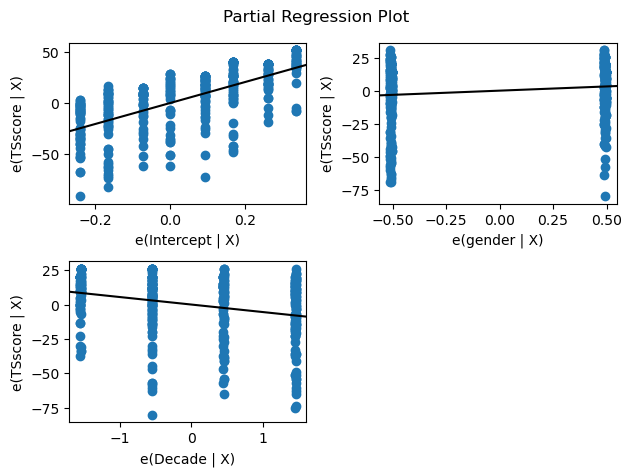

In [81]:
fig = sm.graphics.plot_partregress_grid(res)
fig.tight_layout(pad=1.0)

In [82]:
par = res.params

In [83]:
df_matched_drama.Decade = df_matched_drama.Decade - 4

In [84]:
mod = smf.ols(formula = 'TSscore ~ gender+Decade', data = df_matched_drama.loc[[8,9,10,11]])
res = mod.fit()
print(res.summary())
#1970-2010

                            OLS Regression Results                            
Dep. Variable:                TSscore   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     23.46
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           9.60e-11
Time:                        11:26:28   Log-Likelihood:                -6455.2
No. Observations:                1384   AIC:                         1.292e+04
Df Residuals:                    1381   BIC:                         1.293e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     82.4879      4.446     18.553      0.0

eval_env: 1
eval_env: 1
eval_env: 1


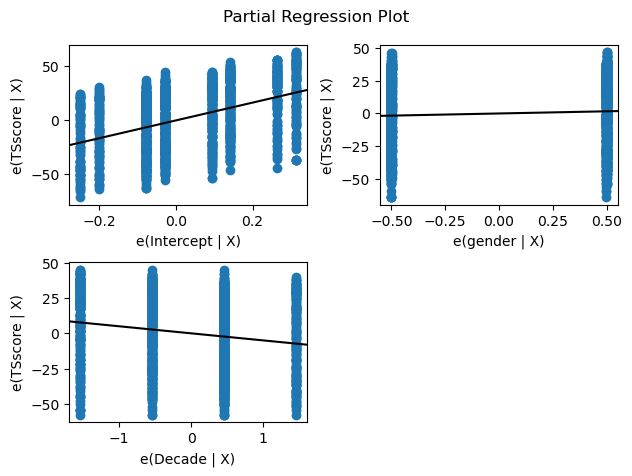

In [85]:
fig = sm.graphics.plot_partregress_grid(res)
fig.tight_layout(pad=1.0)

In [86]:
par2 = res.params

In [87]:
t = np.linspace(0,1,100)

In [88]:
d = np.linspace(4,7,100)

In [89]:
s = t*par[1] + d*par[2] + par[0]

In [90]:
u = t*par2[1] + d*par2[2] + par2[0]

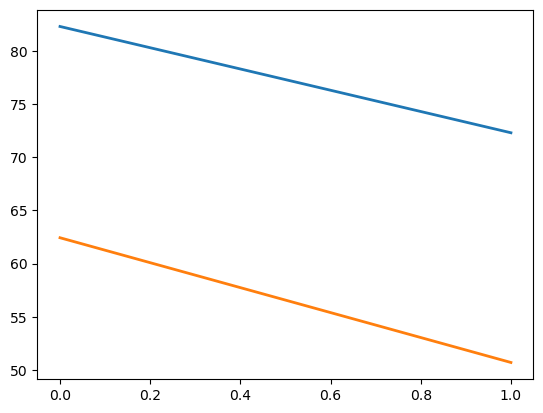

In [91]:
line, = plt.plot(t, s, lw=2)
line, = plt.plot(t, u, lw=2)

In [139]:
mod = smf.ols(formula = 'RTaverage ~ gender+Decade', data = df_matched_drama.loc[[4,5,6,7]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     7.582
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           0.000597
Time:                        11:46:36   Log-Likelihood:                -597.06
No. Observations:                 356   AIC:                             1200.
Df Residuals:                     353   BIC:                             1212.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.1555      0.137     52.317      0.0

eval_env: 1
eval_env: 1
eval_env: 1


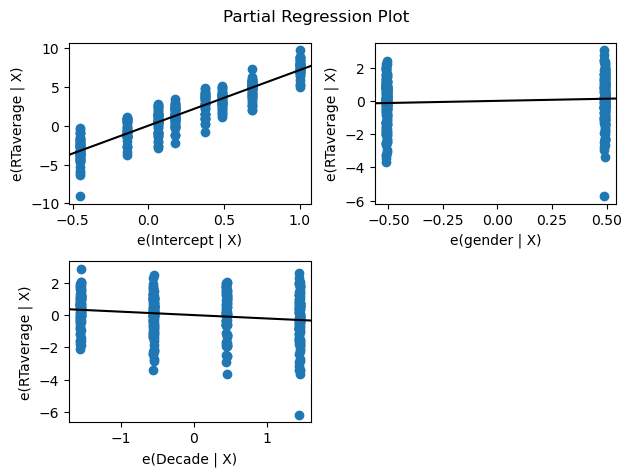

In [140]:
fig = sm.graphics.plot_partregress_grid(res)
fig.tight_layout(pad=1.0)

In [146]:
df_matched_drama

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,TSscore,...,genreLabel,freebase_id,movie,year,Decade,DecadeText,count,Actor_name,Actor_gender,gender
Decade,,,,,,,,,,,,,,,,,,,,,
1,19027655,/m/04jjgs8,Poor Little Peppina,1916-03-02,NaN,48.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",['United States of America'],"['Silent film', 'Black-and-white']",NaN,...,drama film,/m/04jjgs8,Q501281,1916,1,1910-1920,1,Haley Bennett,F,0
1,19200197,/m/04ljb9f,Lovely Mary,1916-03-13,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",['United States of America'],"['Silent film', 'Drama', 'Black-and-white']",NaN,...,drama film,/m/04ljb9f,Q1194241,1916,1,1910-1920,1,Mary Miles Minter,F,0
1,19204861,/m/04lf091,Environment,1917-04-16,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",['United States of America'],"['Silent film', 'Black-and-white']",NaN,...,drama film,/m/04lf091,Q5381007,1917,1,1910-1920,1,Sarah Hyland,F,0
1,73380,/m/0jq5p,Broken Blossoms,1919,NaN,75.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Silent film', 'Indie', 'Black-and-white', 'D...",95.0,...,drama film,/m/0jq5p,Q905932,1919,1,1910-1920,1,Olivia de Havilland,F,0
1,18999400,/m/04jkkms,The Foundling,1916-01-02,NaN,NaN,{},['United States of America'],"['Silent film', 'Drama']",NaN,...,drama film,/m/04jkkms,Q500365,1916,1,1910-1920,1,Mary Pickford,F,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,625714,/m/02y1v6,The Big Kahuna,2000-04-28,3728888.0,91.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Drama', 'Black comedy', 'Comedy-drama', 'Com...",73.0,...,drama film,/m/02y1v6,Q484951,2000,10,2000-2010,1,Kevin Spacey,M,1
10,7224803,/m/0kv0_1,Walking Tall,2004-04-02,NaN,86.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Thriller', 'Crime Fiction', 'Action/Adventur...",26.0,...,drama film,/m/0kv0_1,Q919363,2004,10,2000-2010,1,The Rock,M,1
10,5443971,/m/0dm4k3,The Room,2003,NaN,99.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Cult', 'Black comedy', 'Drama', 'Indie', 'Co...",23.0,...,drama film,/m/0dm4k3,Q533383,2003,10,2000-2010,1,Tommy Wiseau,M,1


In [147]:
mod = smf.ols(formula = 'RTaverage ~ gender+Decade', data = df_matched_drama.loc[[8,9,10,11]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     18.98
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           7.39e-09
Time:                        11:47:53   Log-Likelihood:                -2307.5
No. Observations:                1384   AIC:                             4621.
Df Residuals:                    1381   BIC:                             4637.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.8719      0.376     20.934      0.0

eval_env: 1
eval_env: 1
eval_env: 1


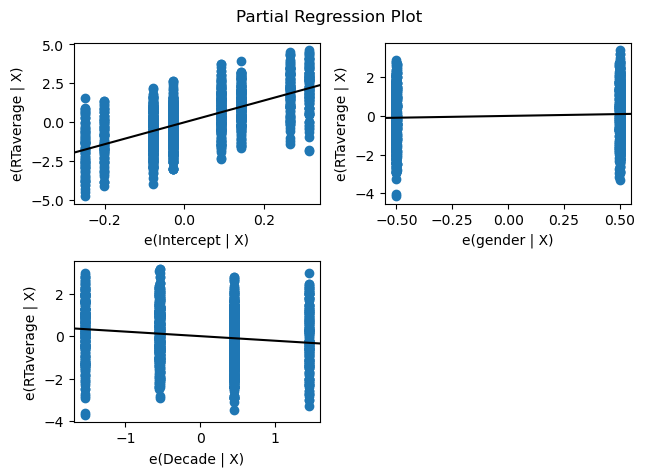

In [95]:
fig = sm.graphics.plot_partregress_grid(res)
fig.tight_layout(pad=1.0)

## Comedy film

In [96]:
comedy = new[new.genreLabel=='comedy film']

In [97]:
comedy = comedy.dropna(subset=['Principal_character_actor'])
dfactor_gender = df_character_usa[['Actor_name','Actor_gender']]
dfactor_gender = dfactor_gender.drop_duplicates()
merge = comedy.merge(dfactor_gender, left_on='Principal_character_actor', right_on='Actor_name', how='left')
comedy = merge.drop(columns=['Principal_character_sex'])
comedy = comedy[(comedy.Actor_gender == 'M') | (comedy.Actor_gender == 'F')]

In [98]:
comedy.Actor_gender.value_counts()

M    989
F    326
Name: Actor_gender, dtype: int64

In [99]:
comedy['gender'] = comedy['Actor_gender'].apply(lambda x: 1 if x =='M' else 0)

In [100]:
comedy = comedy.groupby(['Decade'],group_keys=True).apply(lambda x:x)

In [101]:
comedy.index = comedy.index.droplevel(1)

In [102]:
df_matched_comedy = pd.DataFrame()
# For loop on the unique index in df4
for i in list(comedy.index.value_counts().index):
    count = comedy.loc[i]['gender'].value_counts()               # Count the number of 0 and 1
    l = len(count)                                              # Count number of elements (1 if only 0 or 1)
    df_temp = comedy.loc[i]                                        # temporary DF containing elements that has the same index
    min = count.min()                                           # report the minimum value between number of 0 and number of 1
    if l != 2:                                                  #continue if only 0 or only 1
        continue
    df1 = df_temp[df_temp.gender == 0].sample(min)            # select randomly a number of values corresponding to the minimum occurence of 0 or 1
    df2 = df_temp[df_temp.gender == 1].sample(min)
    df_matched_comedy = pd.concat([df1,df2,df_matched_comedy])                # join the results in df_matched
    

print('The number of actor discarded is : '+ str(len(comedy)-len(df_matched_comedy)))
print('The number of matched pairs is : '+ str(int(len(df_matched_comedy)/2)))

The number of actor discarded is : 663
The number of matched pairs is : 326


In [103]:
df_matched_comedy['TS score_x'] = df_matched_comedy['TS score_x'].str.replace("\%", "", regex=True)
df_matched_comedy['RT average_x'] = df_matched_comedy['RT average_x'].str.split('/').str[0].astype(float)
df_matched_comedy['TS score_x'] = df_matched_comedy['TS score_x'].astype(float)
df_matched_comedy.rename(columns = {'TS score_x':'TSscore', 'RT average_x':'RTaverage'}, inplace = True)

In [104]:
df_matched_comedy = df_matched_comedy.dropna(subset=['Movie_date'])

In [105]:
df_matched_comedy['year'] = df_matched_comedy['Movie_date'].apply(lambda x: int(x[0:4]))

In [106]:
mod = smf.ols(formula = 'RTaverage ~ gender+Decade', data = df_matched_comedy.loc[[4,5,6,7]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     1.897
Date:                Tue, 20 Dec 2022   Prob (F-statistic):              0.160
Time:                        11:26:30   Log-Likelihood:                -78.669
No. Observations:                  56   AIC:                             163.3
Df Residuals:                      53   BIC:                             169.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6350      0.772      9.888      0.0

eval_env: 1
eval_env: 1
eval_env: 1


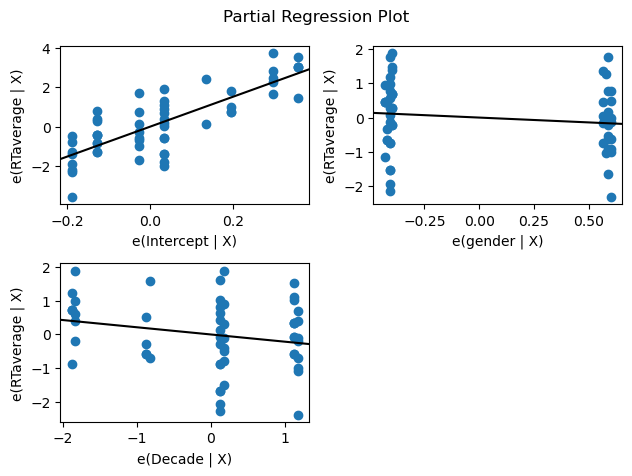

In [107]:
fig = sm.graphics.plot_partregress_grid(res)
fig.tight_layout(pad=1.0)

In [108]:
mod = smf.ols(formula = 'RTaverage ~ gender+Decade', data = df_matched_comedy.loc[[8,9,10,11]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     3.234
Date:                Tue, 20 Dec 2022   Prob (F-statistic):             0.0408
Time:                        11:26:30   Log-Likelihood:                -505.95
No. Observations:                 303   AIC:                             1018.
Df Residuals:                     300   BIC:                             1029.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.6273      0.720      9.200      0.0

eval_env: 1
eval_env: 1
eval_env: 1


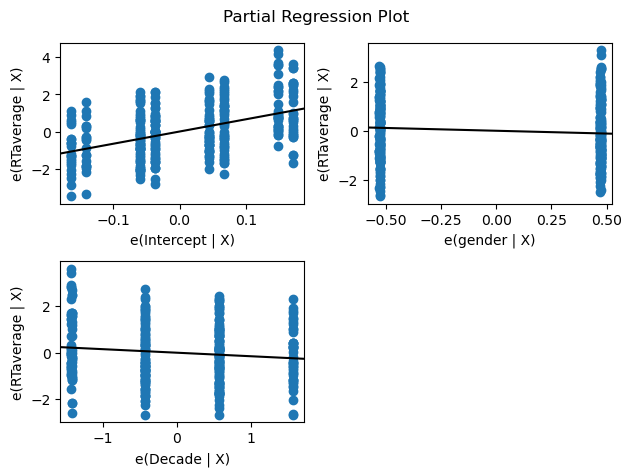

In [109]:
fig = sm.graphics.plot_partregress_grid(res)
fig.tight_layout(pad=1.0)

## Action film

In [110]:
action = new[new.genreLabel=='action film']

In [111]:
action = action.dropna(subset=['Principal_character_actor'])
dfactor_gender = df_character_usa[['Actor_name','Actor_gender']]
dfactor_gender = dfactor_gender.drop_duplicates()
merge = action.merge(dfactor_gender, left_on='Principal_character_actor', right_on='Actor_name', how='left')
action = merge.drop(columns=['Principal_character_sex'])
action = action[(action.Actor_gender == 'M') | (action.Actor_gender == 'F')]

In [112]:
action.Actor_gender.value_counts()

M    490
F    130
Name: Actor_gender, dtype: int64

In [113]:
action['gender'] = action['Actor_gender'].apply(lambda x: 1 if x =='M' else 0)

In [114]:
action = action.groupby(['Decade'],group_keys=True).apply(lambda x:x)

In [115]:
action.index = action.index.droplevel(1)

In [116]:
df_matched_action = pd.DataFrame()
# For loop on the unique index in df4
for i in list(action.index.value_counts().index):
    count = action.loc[i]['gender'].value_counts()               # Count the number of 0 and 1
    l = len(count)                                              # Count number of elements (1 if only 0 or 1)
    df_temp = action.loc[i]                                        # temporary DF containing elements that has the same index
    min = count.min()                                           # report the minimum value between number of 0 and number of 1
    if l != 2:                                                  #continue if only 0 or only 1
        continue
    df1 = df_temp[df_temp.gender == 0].sample(min)            # select randomly a number of values corresponding to the minimum occurence of 0 or 1
    df2 = df_temp[df_temp.gender == 1].sample(min)
    df_matched_action = pd.concat([df1,df2,df_matched_action])                # join the results in df_matched
    

print('The number of athletes discarded is : '+ str(len(action)-len(df_matched_action)))
print('The number of matched pairs is : '+ str(int(len(df_matched_action)/2)))

The number of athletes discarded is : 360
The number of matched pairs is : 130


In [117]:
df_matched_action['TS score_x'] = df_matched_action['TS score_x'].str.replace("\%", "", regex=True)
df_matched_action['RT average_x'] = df_matched_action['RT average_x'].str.split('/').str[0].astype(float)
df_matched_action['TS score_x'] = df_matched_action['TS score_x'].astype(float)
df_matched_action.rename(columns = {'TS score_x':'TSscore', 'RT average_x':'RTaverage'}, inplace = True)

In [118]:
df_matched_action= df_matched_action.dropna(subset=['Movie_date'])

In [119]:
df_matched_action['year'] = df_matched_action['Movie_date'].apply(lambda x: int(x[0:4]))

In [120]:
mod = smf.ols(formula = 'RTaverage ~ gender', data = df_matched_action.loc[[7]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.064
Method:                 Least Squares   F-statistic:                    0.1543
Date:                Tue, 20 Dec 2022   Prob (F-statistic):              0.701
Time:                        11:26:31   Log-Likelihood:                -21.851
No. Observations:                  15   AIC:                             47.70
Df Residuals:                      13   BIC:                             49.12
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3143      0.422     14.976      0.0

/opt/homebrew/Caskroom/miniforge/base/envs/ADA/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1772: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=15



In [121]:
mod = smf.ols(formula = 'RTaverage ~ gender', data = df_matched_action.loc[[8,9,10,11]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.1993
Date:                Tue, 20 Dec 2022   Prob (F-statistic):              0.656
Time:                        11:26:31   Log-Likelihood:                -285.74
No. Observations:                 164   AIC:                             575.5
Df Residuals:                     162   BIC:                             581.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0765      0.154     32.863      0.0

In [122]:
df_movie = pd.read_table(data_folder +'movie.metadata.tsv',header=None)
df_movie.columns=['Wikipedia_movie_ID' , 'Freebase_movie_ID', 'Movie_name' , 'Movie_date' , 'Movie_revenue' , 'Movie_runtime' , 'Movie_languages' , 'Movie_countries' , 'Movie_genres']
df_movie['Movie_countries'] = df_movie['Movie_countries'].apply( lambda x: list(eval(x).values())) #display countries as a list of country names
df_movie['Movie_genres'] = df_movie['Movie_genres'].apply( lambda x: list(eval(x).values()) ) #display genres as a list of genre name
df_movie

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}",[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}",[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}",[Germany],[Drama]
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],[Drama]
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]"
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Satire, Comedy]"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}",[Japan],"[Science Fiction, Japanese Movies, Adventure, ..."


In [123]:
df_movie = df_movie.dropna(subset=['Movie_date'])

In [124]:
df_movie['year'] = df_movie['Movie_date'].apply(lambda x: int(x[0:4]))

/var/folders/yv/q6fl_nv53dv6l2kfbv_6jc680000gn/T/ipykernel_42282/4200689353.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [125]:
count = df_movie.year.value_counts()

In [126]:
decades = ['1900-1910','1910-1920','1920-1930','1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010','2010-2020']
decades_code = range(len(decades))
df_movie['Decade'] = 0
for ctr,decade in enumerate(decades):
    index1 = df_movie[ (df_movie['year']>=int(decade[0:4])) & (df_movie['year']<int(decade[5:9]))].index
    df_movie.loc[index1,'Decade'] = decades_code[ctr]

/var/folders/yv/q6fl_nv53dv6l2kfbv_6jc680000gn/T/ipykernel_42282/651138768.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [127]:
df_movie['Movie_date']

0        2001-08-24
1        2000-02-16
2              1988
3              1987
4              1983
            ...    
81736    2011-03-19
81737    2011-01-21
81738    1972-09-22
81739    1992-05-21
81740          2002
Name: Movie_date, Length: 74839, dtype: object

In [128]:
df_movie

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,year,Decade
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,10
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,10
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}",[Norway],"[Crime Fiction, Drama]",1988,8
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}",[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,8
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}",[Germany],[Drama],1983,8
...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],[Drama],2011,11
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",2011,11
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Satire, Comedy]",1972,7
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}",[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",1992,9


In [129]:
df_movie.Decade.value_counts().sort_values()

0       345
1      2669
2      2883
4      4466
3      4800
11     5228
5      5723
6      5875
7      6716
8      7397
9      9469
10    19268
Name: Decade, dtype: int64

<AxesSubplot:>

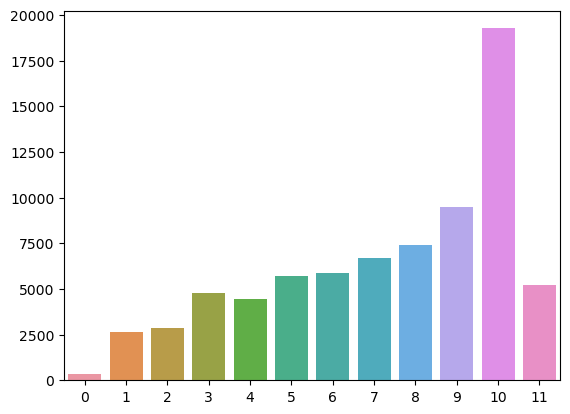

In [130]:
sns.barplot(x=df_movie.Decade.value_counts().sort_values().index, y=df_movie.Decade.value_counts().sort_values().values)

In [131]:
df_character = pd.read_table(data_folder +'character.metadata.tsv',header=None)
df_character.columns=['Wikipedia_movie_ID' , 'Freebase_movie_ID' , 'Movie_date' , 'Character_name' , 'Actor_date_of_birth' , 'Actor_gender' , 'Actor_height' , 'Actor_ethnicity' , 'Actor_name' , 'Actor_age_at_movie_release' , 'Freebase_character_actor_ID' , 'Freebase_character_ID' , 'Freebase_actor_ID'  ]


In [132]:
df_character

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


In [133]:
df_character = df_character.dropna(subset=['Movie_date'])

In [134]:
df_character['year'] = df_character['Movie_date'].apply(lambda x: int(x[0:4]))

/var/folders/yv/q6fl_nv53dv6l2kfbv_6jc680000gn/T/ipykernel_42282/231183615.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [135]:
decades = ['1900-1910','1910-1920','1920-1930','1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010','2010-2020']
decades_code = range(len(decades))
df_character['Decade'] = 0
df_character['Decadetext'] = 0
for ctr,decade in enumerate(decades):
    index1 = df_character[ (df_character['year']>=int(decade[0:4])) & (df_character['year']<int(decade[5:9]))].index
    df_character.loc[index1,'Decade'] = decades_code[ctr]
    df_character.loc[index1,'Decadetext'] = decades[ctr]
    

/var/folders/yv/q6fl_nv53dv6l2kfbv_6jc680000gn/T/ipykernel_42282/625579320.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/yv/q6fl_nv53dv6l2kfbv_6jc680000gn/T/ipykernel_42282/625579320.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [136]:
df_movie_usa = pd.read_csv('df_movie_usa.csv')
df_movie_usa = df_movie_usa.dropna(subset=['Movie_date'])
df_movie_usa['year'] = df_movie_usa['Movie_date'].apply(lambda x: int(x[0:4]))
decades = ['1900-1910','1910-1920','1920-1930','1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010','2010-2020']
decades_code = range(len(decades))
df_movie_usa['Decade'] = 0
for ctr,decade in enumerate(decades):
    index1 = df_movie_usa[ (df_movie_usa['year']>=int(decade[0:4])) & (df_movie_usa['year']<int(decade[5:9]))].index
    df_movie_usa.loc[index1,'Decade'] = decades_code[ctr]

In [137]:
df_movie_usa

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,TS score_x,...,negative_emotion,Number_of_words,he_count,she_count,Principal_summary_character,Secondary_summary_character,Principal_character_sex,Principal_character_actor,year,Decade
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",22%,...,7.0,396.0,1.0,0.0,Ballard,Williams,F,Natasha Henstridge,2001,10
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Mystery', 'Biographical film', 'Drama', 'Cri...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,10
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",['United States of America'],"['Short Film', 'Silent film', 'Indie', 'Black-...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1913,1
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Musical', 'Comedy', 'Black-and-white']",80%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1938,3
4,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Drama', 'Black-and-white']",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1930,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34403,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","['France', 'United States of America']","['Parody', 'Americana', 'Comedy']",85%,...,1.0,252.0,1.0,1.0,Carla,Walt,F,Julia Stiles,2000,10
34404,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,107.0,{},['United States of America'],"['Thriller', 'Erotic thriller', 'Psychological...",38%,...,9.0,611.0,6.0,8.0,Greenhill,Haines,M,Don Johnson,1993,9
34405,24209227,/m/07k5mlk,"The Time, the Place and the Girl",1946,NaN,105.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Comedy film', 'Romance Film', 'Musical']",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1946,4
34406,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],['Drama'],NaN,...,0.0,118.0,0.0,0.0,NaN,NaN,NaN,NaN,2011,11


<AxesSubplot:>

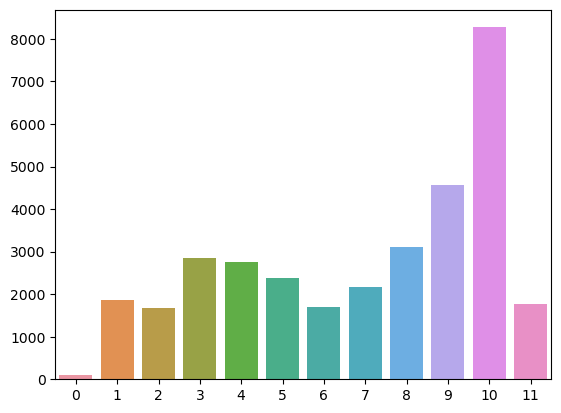

In [138]:
sns.barplot(x=df_movie_usa.Decade.value_counts().sort_values().index, y=df_movie_usa.Decade.value_counts().sort_values().values)